In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import anndata
import scvi
import scanpy as sc
import re
from scipy import sparse
import scanpy.external as sce


/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/flax/struct

In [2]:
cur_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/DIMITRA_FASTQ/"
work_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/"
out_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/out/"
new_out_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/"
plot_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/out/plots/"

references = "/well/immune-rep/users/vbw431/reference/reference/refdata-gex-GRCh38-2020-A/"


In [4]:
##load data 
adata = sc.read_h5ad('/well/immune-rep/users/vbw431/Projects/Peppa/reference_hiv/Wang_HIV.h5ad')

adata.obs["Ref_lab"] = "Wang"
adata.obs["chemistry"] = "3P"
adata.obs["bio_replicate"] = adata.obs["Donor_ID"]
adata.obs["sample_ID"] = adata.obs["Donor_ID"]
adata.obs["study_disease"] = "HIV"
adata.obs["study_ID"] = adata.obs["GEO_ID"]
adata.obs["Treatment_status"] = "Treated"
adata.obs["celltype_consensus.l1"] = "Unknown"
adata.obs["celltype_consensus.l2"] = "Unknown"
adata.obs["HBV_serostatus"] = "nan"
adata.obs["HBV_sAg_titre"] = "nan"
adata.obs["HBV_DNA_VL"] = "nan"
adata.obs["scvi_batch"] = adata.obs["Donor_ID"]
adata.obs["sequencing_batch"] = adata.obs["GEO_ID"]


## Perform QC prior to deconvolution with Hashsolo

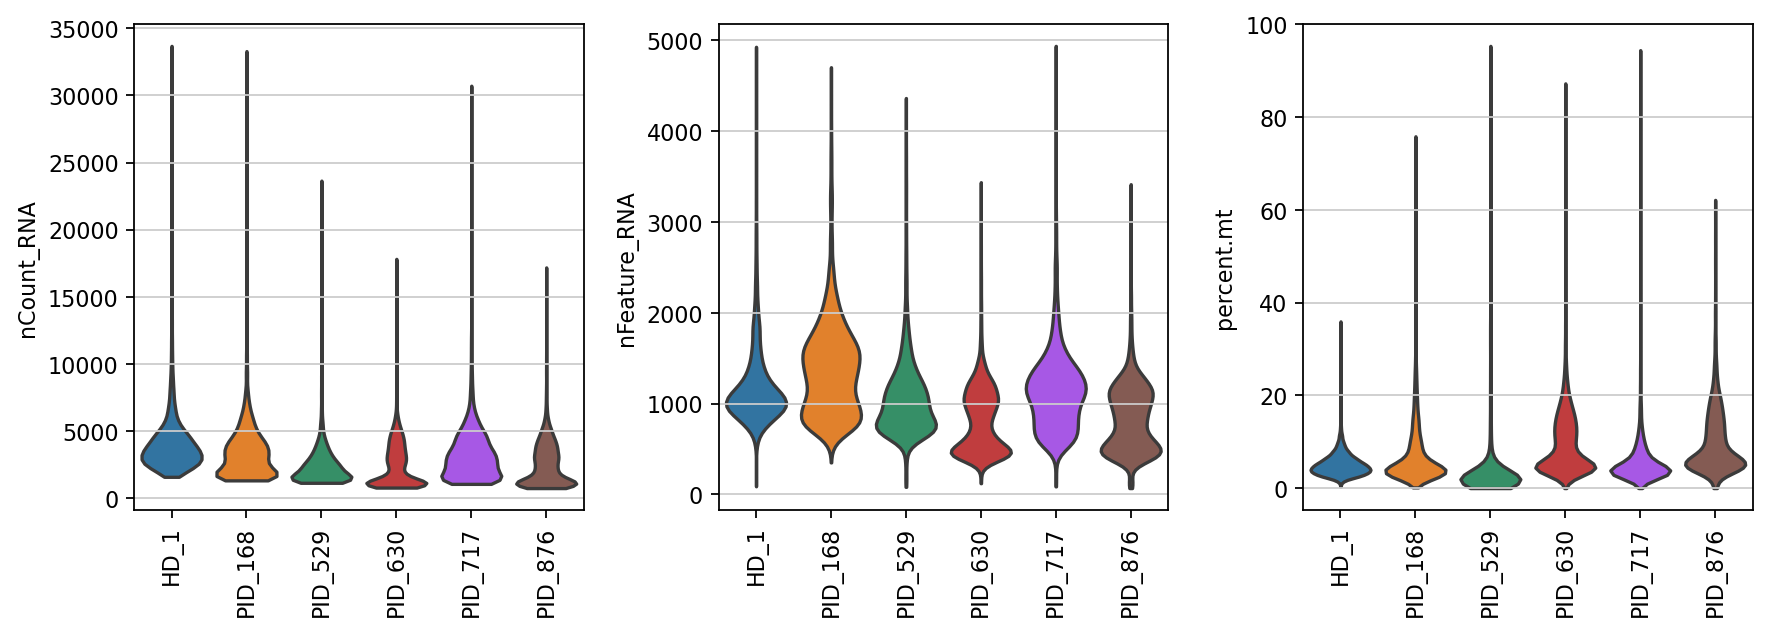

In [5]:
sc.set_figure_params(scanpy=True, fontsize=10)
sc.pl.violin(adata, ['nCount_RNA', 'nFeature_RNA', 'percent.mt'],groupby='sample_ID',stripplot=False,multi_panel=True, rotation=90, ncol=1)



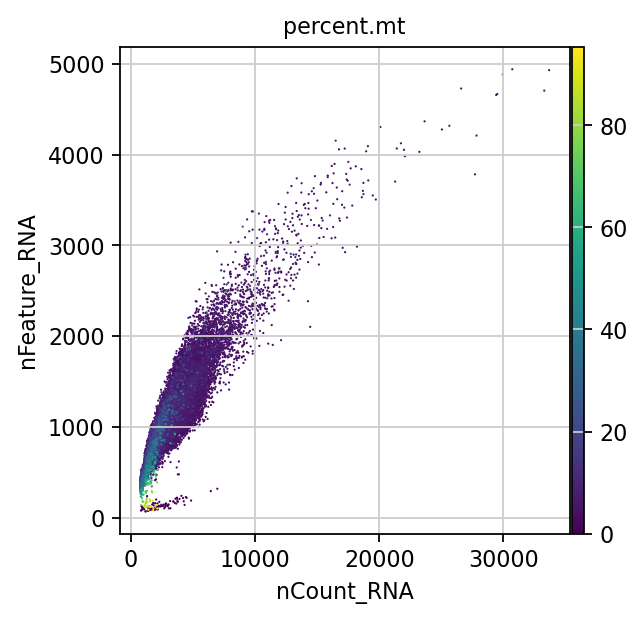

In [8]:
sc.pl.scatter(adata, x='nCount_RNA', y = 'nFeature_RNA', color='percent.mt')

    

In [10]:
conditions = [
        (adata.obs["nCount_RNA"]<200), ##absolute quality thresholds
        (adata.obs["percent.mt"]>20),
        (adata.obs["percent.mt"]>10) & (adata.obs["percent.mt"]<=20),
        (adata.obs["percent.mt"]<=10),
        (adata.obs["nCount_RNA"]>=200)
    ]
# create a list of the values we want to assign for each condition
values = ["critical", "poor", "moderate", "high", "high"]
    
adata.obs["QC_label"] = np.select(conditions, values)
adata.obs["QC_label"].unique().tolist()
    
adata = adata[adata.obs["QC_label"].isin(["high"])].copy()


In [11]:
adata.obs["QC_label"].value_counts()

high    24399
Name: QC_label, dtype: int64

In [12]:
##split anndata
split_list = {label: adata[adata.obs['GEO_ID'] == label].copy() for label in adata.obs['GEO_ID'].unique()}


In [19]:
i

'GSM4775588'

## Run Solo for doublet detection

In [24]:
solo_list = {}

for i in split_list:
    #sc.pp.subsample(adata_list[name], n_obs=20000, random_state=0)
    ## setup model parameters 
    split_list[i].layers["counts"] = split_list[i].X.copy()
    outfile = "/well/immune-rep/users/vbw431/Projects/Peppa/scvi/"+np.array2string(np.unique(set(split_list[i].obs["sample_ID"].astype(str))))+"_model"
    
    #hvg
    sc.pp.highly_variable_genes(
        split_list[i],
        n_top_genes=3000,
        flavor = "seurat_v3",
        subset=True)
    
    ## train model
    early_stopping_kwargs = {
        "early_stopping": True,
        "early_stopping_monitor": "elbo_validation",
        "early_stopping_patience": 10,
        "early_stopping_min_delta": 0.001,
        }
    scvi.model.SCVI.setup_anndata(split_list[i])
    vae = scvi.model.SCVI(split_list[i])
    vae.train(max_epochs = 500, **early_stopping_kwargs)
    vae.save(outfile, save_anndata=True,overwrite=True)
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    solo.predict()
    
    solo_list[i] = solo




/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /well/immune-rep/users/vbw431/conda/skylake/envs/scv ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightni

Epoch 121/500:  24%|▏| 121/500 [01:15<03:56,  1.60it/s, v_num=1, train_loss_step
Monitored metric elbo_validation did not improve in the last 10 records. Best score: 794.668. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /well/immune-rep/users/vbw431/conda/skylake/envs/scv ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightni

Epoch 233/400:  58%|▌| 233/400 [01:06<00:47,  3.50it/s, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.141. Signaling Trainer to stop.


/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /well/immune-rep/users/vbw431/conda/skylake/envs/scv ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightni

Epoch 129/500:  26%|▎| 129/500 [00:35<01:42,  3.62it/s, v_num=1, train_loss_step
Monitored metric elbo_validation did not improve in the last 10 records. Best score: 849.837. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /well/immune-rep/users/vbw431/conda/skylake/envs/scv ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightni

Epoch 293/400:  73%|▋| 293/400 [00:47<00:17,  6.11it/s, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.230. Signaling Trainer to stop.


/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /well/immune-rep/users/vbw431/conda/skylake/envs/scv ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightni

Epoch 69/500:  14%|▏| 69/500 [00:13<01:25,  5.02it/s, v_num=1, train_loss_step=6
Monitored metric elbo_validation did not improve in the last 10 records. Best score: 695.629. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /well/immune-rep/users/vbw431/conda/skylake/envs/scv ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightni

Epoch 303/400:  76%|▊| 303/400 [00:40<00:12,  7.52it/s, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.226. Signaling Trainer to stop.


/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /well/immune-rep/users/vbw431/conda/skylake/envs/scv ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightni

Epoch 98/500:  20%|▏| 98/500 [00:30<02:05,  3.21it/s, v_num=1, train_loss_step=7
Monitored metric elbo_validation did not improve in the last 10 records. Best score: 870.485. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /well/immune-rep/users/vbw431/conda/skylake/envs/scv ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightni

Epoch 260/400:  65%|▋| 260/400 [00:46<00:25,  5.55it/s, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.206. Signaling Trainer to stop.


/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /well/immune-rep/users/vbw431/conda/skylake/envs/scv ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightni

Epoch 138/500:  28%|▎| 138/500 [00:32<01:24,  4.26it/s, v_num=1, train_loss_step
Monitored metric elbo_validation did not improve in the last 10 records. Best score: 764.506. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /well/immune-rep/users/vbw431/conda/skylake/envs/scv ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightni

Epoch 282/400:  70%|▋| 282/400 [00:41<00:17,  6.79it/s, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.241. Signaling Trainer to stop.


/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /well/immune-rep/users/vbw431/conda/skylake/envs/scv ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightni

Epoch 157/500:  31%|▎| 157/500 [00:43<01:35,  3.58it/s, v_num=1, train_loss_step
Monitored metric elbo_validation did not improve in the last 10 records. Best score: 959.988. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /well/immune-rep/users/vbw431/conda/skylake/envs/scv ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/lightni

Epoch 225/400:  56%|▌| 225/400 [00:34<00:27,  6.45it/s, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.228. Signaling Trainer to stop.


In [25]:
##save models 
for i in split_list:
    #sc.pp.subsample(adata_list[name], n_obs=20000, random_state=0)
    ## setup model parameters 
    outfile = "/well/immune-rep/users/vbw431/Projects/Peppa/scvi/"+np.array2string(np.unique(set(split_list[i].obs["sample_ID"].astype(str))))+"_solo_model"
    solo_list[i].save(outfile, save_anndata=True,overwrite=True)
    

In [27]:
##predict soft and hard results for solo

for i in split_list:
    #sc.pp.subsample(adata_list[name], n_obs=20000, random_state=0)
    ## setup model parameters 
    solo_soft = solo_list[i].predict(soft = True)
    solo_soft.index = split_list[i].obs_names
    split_list[i].obs["solo_doublet_prob"] = solo_soft["doublet"]
    split_list[i].obs["solo_singlet_prob"] = solo_soft["singlet"]
    solo_hard = solo_list[i].predict(soft = False)
    solo_hard.index = split_list[i].obs_names
    split_list[i].obs["solo_classification"] = solo_hard


In [28]:
batch_list = []

for i in split_list:
    value = set(split_list[i].obs["sample_ID"].astype(str))
    batch_list.extend(value)

In [29]:
for i in split_list:
    print(split_list[i].shape)


(6606, 3000)
(3786, 3000)
(3021, 3000)
(4085, 3000)
(3351, 3000)
(3550, 3000)


In [31]:
adata.obs["batch"] = adata.obs["sample_ID"].copy()


In [34]:
concat_adata = anndata.concat(split_list)

In [35]:
concat_adata

AnnData object with n_obs × n_vars = 24399 × 599
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'GEO_ID', 'Donor_ID', 'Age', 'Sex', 'Ethnicity', 'Duration_infection_years', 'Suppresion', 'ART_therapy', 'PlasmaHIVRNA_copies_ml', 'Infection_stage', 'CD4_count_cells_ul', 'Ref_lab', 'chemistry', 'bio_replicate', 'sample_ID', 'study_disease', 'study_ID', 'Treatment_status', 'celltype_consensus.l1', 'celltype_consensus.l2', 'HBV_serostatus', 'HBV_sAg_titre', 'HBV_DNA_VL', 'scvi_batch', 'sequencing_batch', 'QC_label', '_scvi_batch', '_scvi_labels', 'solo_doublet_prob', 'solo_singlet_prob', 'solo_classification'
    layers: 'counts'

## Assign biological sample IDs

In [36]:
# Extract the relevant columns from the source AnnData object
source_cols = concat_adata.obs[['solo_doublet_prob', 'solo_singlet_prob', 'solo_classification']]

# Merge with the target AnnData object's obs dataframe
adata.obs = adata.obs.merge(source_cols, left_index=True, right_index=True, how='left')

## Remove doublets

In [37]:
#adata_all = adata_all[adata_all.obs["solo_classification"] != "doublet"].copy()
##save for downstream
adata.write("/well/immune-rep/users/vbw431/Projects/Peppa/reference_hiv/Wang_postQC.h5ad")
